In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

In [211]:
# Read csv into Pandas dataframe
movies_dataframe = pd.read_csv('movie_metadata.csv')
movies_dataframe.head(5)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [212]:
movies_dataframe.shape

(5043, 28)

In [213]:
# PRE-PROCESSING
# Remove all movies made outside the USA
movies_dataframe = movies_dataframe.drop(movies_dataframe[movies_dataframe.country != 'USA'].index)
# Any block with missing information was to be set to 0
movies_dataframe = movies_dataframe.fillna(0)

# To fix an issue that would later appear, all samples with the "Color" feature set to 0, 
# meaning that the field was empty, is to be dropped.
movies_dataframe = movies_dataframe.drop(movies_dataframe[movies_dataframe.color == 0].index)

# Subtract budget from gross to calculate profits and add it as a new feature
movies_dataframe['profit'] = np.subtract(movies_dataframe[['gross']], movies_dataframe[['budget']])


movies_dataframe.head(5)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,profit
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000,523505847.0
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0,9404152.0
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000,198130642.0
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000,-190641321.0
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,...,English,USA,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0,78530303.0


In [214]:
movies_dataframe.shape

(3793, 29)

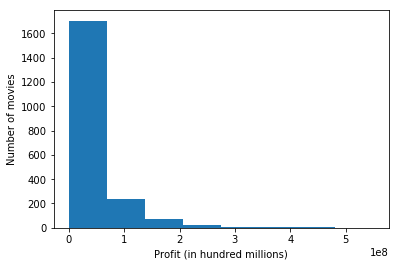

profit    523505847.0
dtype: float64


In [215]:
# Graph for Profits vs Number of Movies
%matplotlib inline
plt.hist(movies_dataframe['profit'], bins=8, normed=False, range=(0, 550000000))

plt.xlabel('Profit (in hundred millions)')
plt.ylabel('Number of movies')
plt.show()

# We also want to see what the most profitable movie in our dataset made
# We will also use our maximum profit number for limits
max_gross = movies_dataframe[['profit']].max()
print(max_gross)

<dl>
    <dt><h3>Movie Info</h3></dt>
    <dd><em>IMDB Score, Budget, Duration, Title Year</em></dd>
</dl>

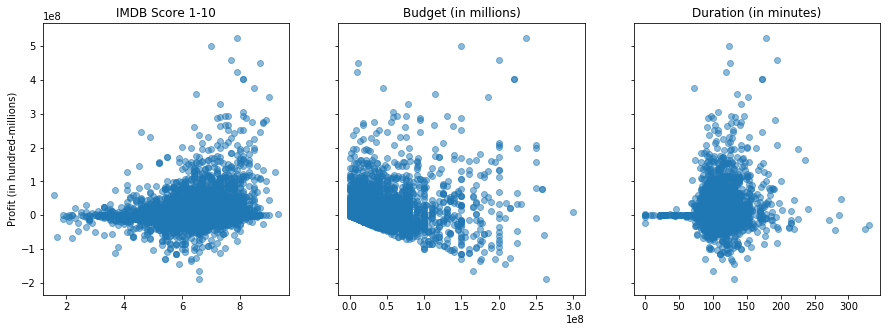

In [216]:
figure, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (15, 5))
ax1.scatter(movies_dataframe['imdb_score'], movies_dataframe['profit'], alpha = 0.5)
ax2.scatter(movies_dataframe['budget'], movies_dataframe['profit'], alpha = 0.5)
ax3.scatter(movies_dataframe['duration'], movies_dataframe['profit'], alpha = 0.5)

ax1.set_ylabel('Profit (in hundred-millions)')
ax1.set_title('IMDB Score 1-10')
ax2.set_title('Budget (in millions)')
ax3.set_title('Duration (in minutes)')

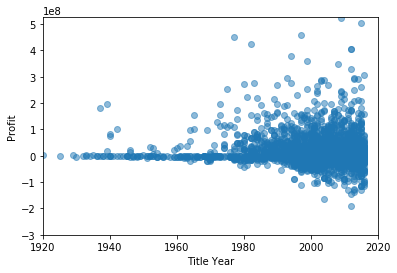

In [217]:
# Profit vs. Title Year

x_axis = movies_dataframe[['title_year']]
y = movies_dataframe[['profit']]

plt.ylabel('Profit')
plt.xlabel('Title Year')

plt.ylim([-300000000, 525000000])   #Profit range of -$300M - $525M
plt.xlim([1920, 2020])              #Title Year range of 1920 - 2020
plt.scatter(x_axis, y, alpha=0.5)
plt.show()

<dl>
    <dt></dt>
    <dd>Patterns that correlate with a movie's profit can clearly be seen with IMDB score, budget, and duration.  IMDB Score shows a relative rise in profit as a movie's rating increases to a point.  Budget and duration show that most movies follow a standard format.
    <br /><br />
    Title Year should be evaluated with a bit of scrutiny.  The vast majority of samples occur after the year 1980.  Profit values have also not been adjusted for inflation which would also explain for such a rise in earnings for movies.  To adjust for this we will consider movies before 1980 to be outliers and drop them from the dataset.  This fits within the scope of this project as recent movies will have the largest impact.  This will be our new dataset.</dd>
</dl>

In [227]:
# Drop samples with Title Year before 1980
movies_dataframe = movies_dataframe.drop(movies_dataframe[movies_dataframe.title_year < 1980].index)

# Checking new dataframe size for change.  OLD: (3793, 29)
movies_dataframe.shape

(3517, 31)

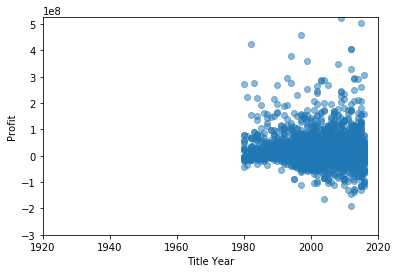

In [228]:
# Profit vs. Title Year (Revised)

x_axis = movies_dataframe[['title_year']]
y = movies_dataframe[['profit']]
%matplotlib inline

plt.ylabel('Profit')
plt.xlabel('Title Year')

plt.ylim([-300000000, 525000000])   #Profit range of -$300M - $525M
plt.xlim([1920, 2020])              #Title Year range of 1920 - 2020 to show change
plt.scatter(x_axis, y, alpha=0.5)
plt.show()

<dl>
    <dt><h3>Ratings Info</h3></dt>
    <dd><em>Number of Critic Reviews, User Reviews, Voted Users</em></dd>
</dl>

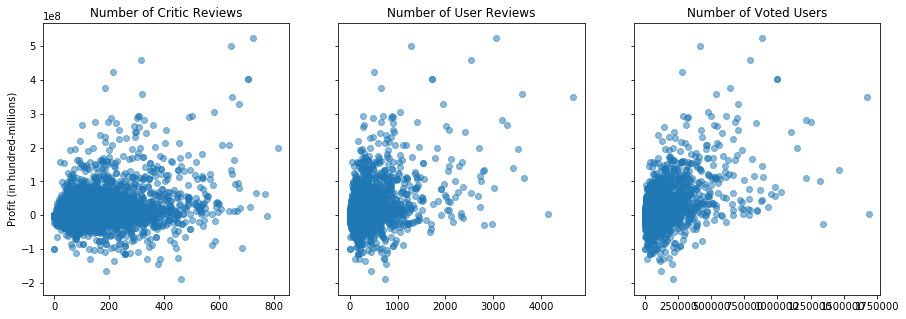

In [221]:
figure, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (15, 5))
ax1.scatter(movies_dataframe['num_critic_for_reviews'], movies_dataframe['profit'], alpha = 0.5)
ax2.scatter(movies_dataframe['num_user_for_reviews'], movies_dataframe['profit'], alpha = 0.5)
ax3.scatter(movies_dataframe['num_voted_users'], movies_dataframe['profit'], alpha = 0.5)

ax1.set_ylabel('Profit (in hundred-millions)')
ax1.set_title('Number of Critic Reviews')
ax2.set_title('Number of User Reviews')
ax3.set_title('Number of Voted Users')

<dl>
    <dt></dt>
    <dd>All three ratings features present valuable information.
    </dd>
</dl>

<dl>
    <dt><h3>Miscellaneous</h3></dt>
    <dd><em>Face Number in Poster, Color</em></dd>
</dl>

In [230]:
# Function to convert color values to binary values
def color_to_numeric(x):
    if x == 'Color':
        return 1;
    else:
        return 0;
    
# Creates a new feature named colorlabel using converted values
movies_dataframe['colorlabel'] = movies_dataframe['color'].apply(color_to_numeric)
movies_dataframe.head(5)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,profit,colorlabel,profitlabel
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000,523505847.0,1,2
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0,9404152.0,1,2
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000,198130642.0,1,2
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000,-190641321.0,1,1
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,...,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0,78530303.0,1,2


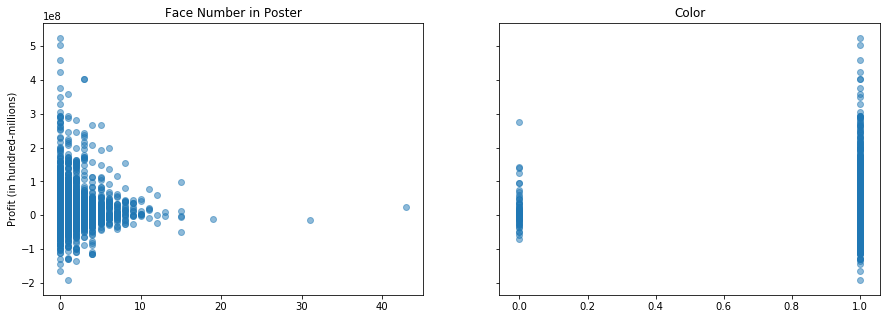

In [223]:
figure, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (15, 5))
ax1.scatter(movies_dataframe['facenumber_in_poster'], movies_dataframe['profit'], alpha = 0.5)
ax2.scatter(movies_dataframe['colorlabel'], movies_dataframe['profit'], alpha = 0.5)

ax1.set_ylabel('Profit (in hundred-millions)')
ax1.set_title('Face Number in Poster')
ax2.set_title('Color')

<dl>
    <dt></dt>
    <dd>Facenumber in Poster is surprisingly informative.  It shows that the number of faces in a movie poster correlates negatively with a movie's profits.  Movies with 0 faces tend to do much better than movies with even just 1 face and linearly decreases as more faces are added.
    <br /><br />
    Color's results are expected.  Almost all recent movies are color, but there are a fair amount of samples for black and white movies and many that did well.
    </dd>
</dl>

<dl>
    <dt><h3>Facebook Info</h3></dt>
    <dd><em>Movie Facebook Likes, Cast Total Facebook Likes, Director Facebook Likes</em></dd>
</dl>

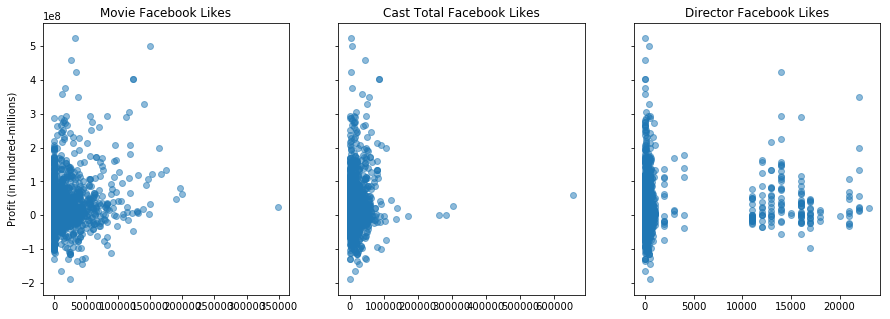

In [224]:
figure, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (15, 5))
ax1.scatter(movies_dataframe['movie_facebook_likes'], movies_dataframe['profit'], alpha = 0.5)
ax2.scatter(movies_dataframe['cast_total_facebook_likes'], movies_dataframe['profit'], alpha = 0.5)
ax3.scatter(movies_dataframe['director_facebook_likes'], movies_dataframe['profit'], alpha = 0.5)

ax1.set_ylabel('Profit (in hundred-millions)')
ax1.set_title('Movie Facebook Likes')
ax2.set_title('Cast Total Facebook Likes')
ax3.set_title('Director Facebook Likes')

<dl>
    <dt></dt>
    <dd>Facebook's influence on a movie's profits can only be calculated on movies made after facebook's creation and rise in popularity.  To include facebook's data in our dataset we would need to eliminate many movies from the dataset.  It is for this reason any of the facebook features will not be included.  Nevertheless, it is still interesting to see what the pyplots show for the data. <br  />
    </dd>
</dl>

### Determining most influential features

In [226]:
def profit_to_numeric(x):
    int(x)
    if x == 0:      # If profit = 0
        return 0
    elif x < 0:     # If profit < 0
        return 1
    elif x > 0:     # If profit > 0
        return 2
    
movies_dataframe['profitlabel'] = movies_dataframe['profit'].apply(profit_to_numeric)
movies_dataframe.head(5)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,profit,colorlabel,profitlabel
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000,523505847.0,1,2
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0,9404152.0,1,2
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000,198130642.0,1,2
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000,-190641321.0,1,1
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,...,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0,78530303.0,1,2


In [25]:
#feature_cols = ['imdb_score', 'budget', 'duration', 'title_year', 'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users', 'facenumber_in_poster', 'colorlabel']
#feature_cols = ['imdb_score', 'budget', 'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users', 'facenumber_in_poster']

X = movies_dataframe[['imdb_score', 'budget', 'duration', 'title_year', 'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users', 'facenumber_in_poster', 'colorlabel']]
profitable = movies_dataframe['profitlabel']

X_train, X_test, y_train, y_test = train_test_split(X, profitable, test_size=0.3, random_state=1)

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)

score = accuracy_score(y_test, y_predict)
print(score)

0.652462121212


In [26]:
#feature_cols = ['imdb_score']
X = movies_dataframe[['imdb_score']]

X_train, X_test, y_train, y_test = train_test_split(X, profitable, test_size=0.4, random_state=1)

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
score = accuracy_score(y_test, y_predict)
print(score)

0.525941719972


In [27]:
feature_cols = ['colorlabel']
X = movies_dataframe[['colorlabel']]

X_train, X_test, y_train, y_test = train_test_split(X, profitable, test_size=0.4, random_state=1)

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
score = accuracy_score(y_test, y_predict)
print(score)

0.524520255864


In [28]:
#feature_cols = ['num_user_for_reviews']
X = movies_dataframe[['num_user_for_reviews']]

X_train, X_test, y_train, y_test = train_test_split(X, profitable, test_size=0.4, random_state=1)

#knn = KNeighborsClassifier(n_neighbors = 5)
#knn.fit(X_train, y_train)
#y_predict = knn.predict(X_test)
score = accuracy_score(y_test, y_predict)
print(score)

0.524520255864


In [29]:
feature_cols = ['budget']
X = movies_dataframe[feature_cols]

X_train, X_test, y_train, y_test = train_test_split(X, profitable, test_size=0.4, random_state=1)

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
score = accuracy_score(y_test, y_predict)
print(score)

0.5486851457


In [30]:
feature_cols = ['facenumber_in_poster']
X = movies_dataframe[feature_cols]

X_train, X_test, y_train, y_test = train_test_split(X, profitable, test_size=0.4, random_state=1)

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
score = accuracy_score(y_test, y_predict)
print(score)

0.477611940299


In [31]:
feature_cols = ['gross']
X = movies_dataframe[feature_cols]

X_train, X_test, y_train, y_test = train_test_split(X, profitable, test_size=0.4, random_state=1)

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
score = accuracy_score(y_test, y_predict)
print(score)

0.666666666667


In [32]:
feature_cols = ['title_year']
X = movies_dataframe[feature_cols]

X_train, X_test, y_train, y_test = train_test_split(X, profitable, test_size=0.4, random_state=1)

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
score = accuracy_score(y_test, y_predict)
print(score)

0.488272921109


In [33]:
feature_cols = ['num_critic_for_reviews']
X = movies_dataframe[feature_cols]

X_train, X_test, y_train, y_test = train_test_split(X, profitable, test_size=0.4, random_state=1)

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
score = accuracy_score(y_test, y_predict)
print(score)

0.557924662402


In [34]:
feature_cols = ['num_voted_users']
X = movies_dataframe[feature_cols]

X_train, X_test, y_train, y_test = train_test_split(X, profitable, test_size=0.4, random_state=1)

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
score = accuracy_score(y_test, y_predict)
print(score)

0.582800284293


In [35]:
feature_cols = ['duration']
X = movies_dataframe[feature_cols]

X_train, X_test, y_train, y_test = train_test_split(X, profitable, test_size=0.4, random_state=1)

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
score = accuracy_score(y_test, y_predict)
print(score)

0.488272921109


### Normalization of feature matrix

In [36]:
feature_scaled = movies_dataframe[['imdb_score', 'budget', 'duration', 'title_year', 'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users', 'facenumber_in_poster', 'colorlabel']]
feature_scaled = feature_scaled.apply(lambda x: ((x - x.min()) / (x.max() - x.min())))

feature_scaled.head()

,imdb_score,budget,duration,title_year,num_critic_for_reviews,num_user_for_reviews,num_voted_users,facenumber_in_poster,colorlabel
0,0.818182,0.790000,0.539394,0.805556,0.889299,0.654382,0.524453,0.000000,1.0
1,0.714286,1.000000,0.512121,0.750000,0.371464,0.265267,0.278865,0.000000,1.0
3,0.896104,0.833333,0.496970,0.888889,1.000000,0.578744,0.677216,0.000000,1.0
5,0.649351,0.879000,0.400000,0.888889,0.568266,0.158132,0.125579,0.023256,1.0
6,0.597403,0.860000,0.472727,0.750000,0.482165,0.407542,0.226690,0.000000,1.0


### Splitting the dataset

In [37]:
X_train, X_test, y_train, y_test = train_test_split(feature_scaled, y, random_state=2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2637, 9)
(2637, 1)
(880, 9)
(880, 1)


### Linear Regression

In [38]:
linReg = LinearRegression()
linReg.fit(X_train, y_train)

print(linReg.intercept_)
print('')
print(linReg.coef_)

[ 8654399.82902401]

[[  3.36477072e+06  -6.44628616e+07  -3.72915573e+07  -1.82640721e+07
    1.53425197e+07   3.35471601e+07   2.80126609e+08   2.08708322e+07
    1.41562616e+07]]


In [39]:
testing_set_prediction = linReg.predict(X_test)

# Calculate the mean square error of testing
mse = metrics.mean_squared_error(y_test, testing_set_prediction)

# Calculate the root mean square error of testing
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

RMSE:  44783592.7342


### 10-Fold Cross Validation

In [40]:
mse_list = cross_val_score(linReg, feature_scaled, y, cv = 10, scoring='neg_mean_squared_error')

print(mse_list)

[ -7.03122281e+15  -3.76339488e+15  -1.70585782e+15  -1.37902645e+15
  -1.89880194e+15  -1.14177380e+15  -1.15521573e+15  -8.71745863e+14
  -3.45854271e+14  -1.41721036e+14]


In [41]:
# Next we must remove negative numbers to calculate rmse
mse_list_pos = -mse_list              # Create a copy of negated values
rmse_list = np.sqrt(mse_list_pos)     # Sqrt the copy

print(rmse_list)

[ 83852387.00665016  61346514.80368376  41302031.66287243
  37135245.34695198  43575244.59780503  33790143.48587293
  33988464.61070091  29525342.72168111  18597157.6023379   11904664.46869294]


In [42]:
# Print out our average RMSE and average error
print('Average rmse: ', rmse_list.mean())
print('Average error: ', rmse_list.mean()/525000000) # Divide by range of 760505847

Average rmse:  39501719.6307
Average error:  0.0752413707252


In [193]:
counter1 = 0
for x in movies_dataframe['profit']:
    float(x)
    if x > 0:
        counter1 = counter1 + 1
print(counter1)

1921


In [44]:
#testx = np.array(movies_dataframe[['imdb_score', 'budget', 'duration', 'title_year', 'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users', 'facenumber_in_poster', 'colorlabel']])
X = np.array(X.iloc[:, 0:9])
#'imdb_score', 'budget', 'duration', 'title_year', 'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users', 'facenumber_in_poster', 'colorlabel']

#testx = np.array(movies_dataframe.iloc[:, 0:29])
y = np.array(movies_dataframe['profitlabel'])
print(testx)

NameError: name 'testx' is not defined

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
print(accuracy_score(y_test, pred))

0.503787878788


In [236]:
#X = movies_dataframe[['imdb_score', 'budget', 'duration', 'title_year', 'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users', 'facenumber_in_poster', 'colorlabel']]
#y = movies_dataframe['profitlabel']

knn_list = list(range(1,50))
neighbors = filter(lambda x: x % 2 != 0, knn_list)

cv_scores = []

for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors = n)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring = 'accuracy')
    cv_scores.append(scores.mean())

mean_square = [1 - x for x in cv_scores]

op_k = neighbors[mean_square.index(min(mean_square))]
print(op_k)

plt.plot(neighbors, mean_square)

TypeError: 'filter' object is not subscriptable

In [241]:
feature_scaled = movies_dataframe[['imdb_score', 'budget', 'duration', 'title_year', 'gross', 'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users', 'facenumber_in_poster', 'colorlabel', 'profit']]
feature_scaled = feature_scaled.apply(lambda x: ((x - x.min()) / (x.max() - x.min())))

feature_scaled.head()

,imdb_score,budget,duration,title_year,gross,num_critic_for_reviews,num_user_for_reviews,num_voted_users,facenumber_in_poster,colorlabel,profit
0,0.818182,0.790000,0.539394,0.805556,1.000000,0.889299,0.654382,0.524453,0.000000,1.0,1.000000
1,0.714286,1.000000,0.512121,0.750000,0.406840,0.371464,0.265267,0.278865,0.000000,1.0,0.280118
3,0.896104,0.833333,0.496970,0.888889,0.589253,1.000000,0.578744,0.677216,0.000000,1.0,0.544386
5,0.649351,0.879000,0.400000,0.888889,0.096066,0.568266,0.158132,0.125579,0.023256,1.0,0.000000
6,0.597403,0.860000,0.472727,0.750000,0.442509,0.482165,0.407542,0.226690,0.000000,1.0,0.376913


In [242]:
feature_scaled.corr()[['profit']]

,profit
imdb_score,0.261887
budget,0.093429
duration,0.134239
title_year,-0.087480
gross,0.791712
num_critic_for_reviews,0.275909
num_user_for_reviews,0.403119
num_voted_users,0.514588
facenumber_in_poster,-0.019265
colorlabel,0.005463


In [243]:
movies_dataframe.corr()[['profit']]

,profit
num_critic_for_reviews,0.275909
duration,0.134239
director_facebook_likes,0.112679
actor_3_facebook_likes,0.190350
actor_1_facebook_likes,0.061687
gross,0.791712
num_voted_users,0.514588
cast_total_facebook_likes,0.119359
facenumber_in_poster,-0.019265
num_user_for_reviews,0.403119
